In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
import sys
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Import our CNN denoiser model
sys.path.append("../Modules")
from spectroscopy_models import cnn_denoiser

Shape: # of samples x length of samples x # of transients
(270, 256, 20)
(270, 256)


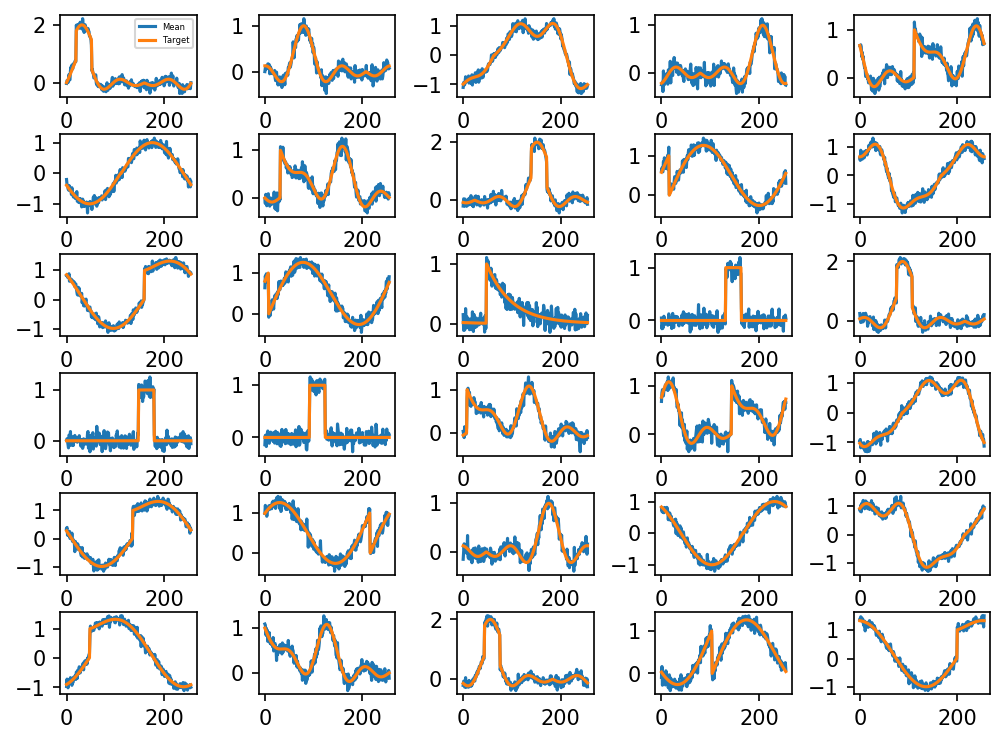

In [2]:
# Load dataset
transients = np.load("noisy_transients.npy")
target = np.load("reference.npy")
print("Shape: # of samples x length of samples x # of transients")
print(transients.shape)
print(target.shape)

# Displaying some samples in the dataset
plt.figure(figsize = (8,6),dpi = 150)
gs1 = gridspec.GridSpec(6, 5)
gs1.update(wspace=0.45, hspace=0.45)

for ii in range(30):
    plt.subplot(gs1[ii])
    plt.plot(transients[ii].mean(axis = -1).T,label = 'Mean')
    plt.plot(target[ii].T, label = "Target")
    if (ii == 0):
        plt.legend(fontsize = 4)
plt.show()

In [3]:
# Splitting our dataset into train/validation/test sets
split_indexes = 180,240 # Arbitrary choice here


train = transients[:split_indexes[0]]
train_target = target[:split_indexes[0]]

val = transients[split_indexes[0]:split_indexes[1]]
val_target = target[split_indexes[0]:split_indexes[1]]

test = transients[split_indexes[1]:]
test_target = target[split_indexes[1]:]


# Normalization by mean and std of train set
norm_mean = train.mean()
norm_std = train.std()

train = (train-norm_mean)/norm_std
train_target = (train_target-norm_mean)/norm_std

val = (val-norm_mean)/norm_std
val_target = (val_target-norm_mean)/norm_std

# The test target doesn't need to be normalized
test = (test-norm_mean)/norm_std

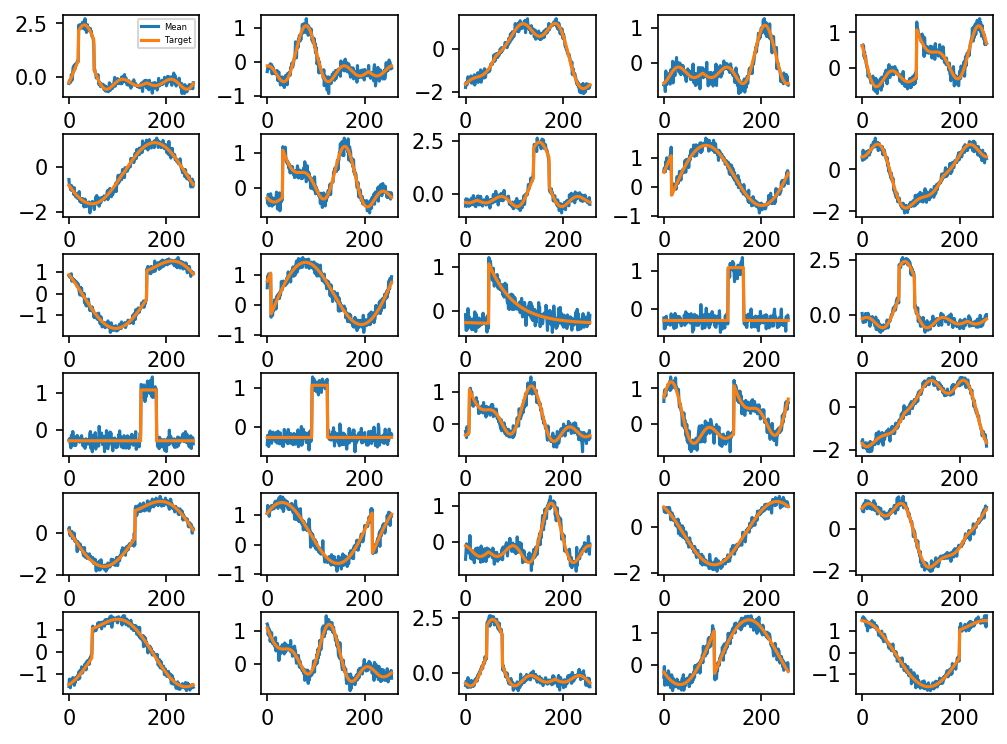

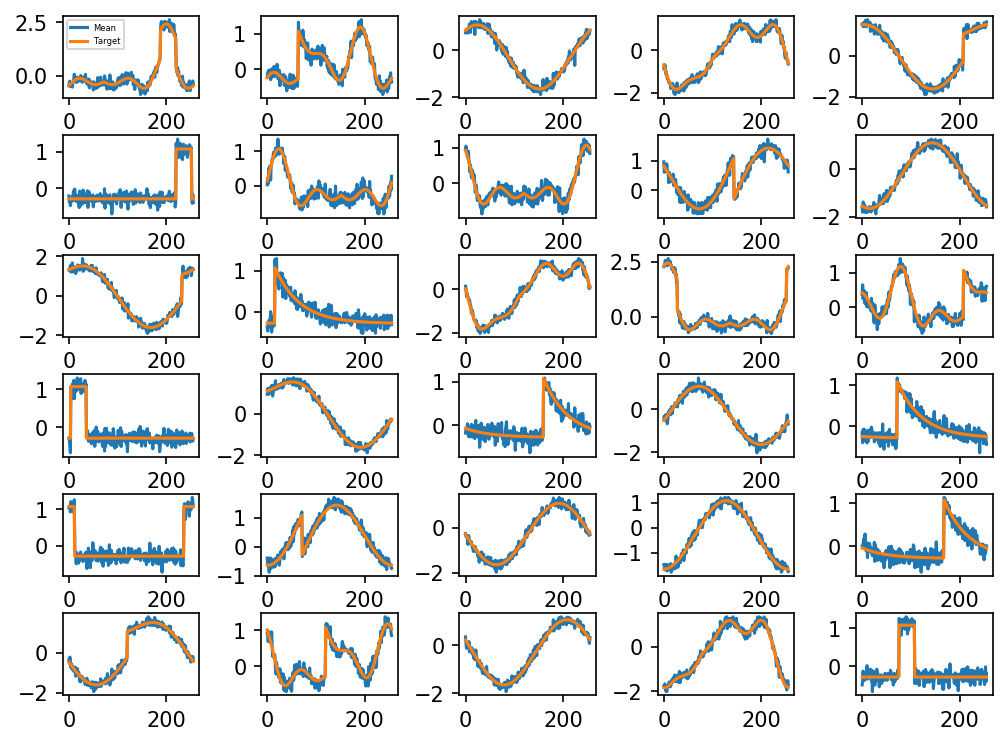

In [4]:
# Displaying some samples in the train
plt.figure(figsize = (8,6),dpi = 150)
gs1 = gridspec.GridSpec(6, 5)
gs1.update(wspace=0.45, hspace=0.45)

for ii in range(30):
    plt.subplot(gs1[ii])
    plt.plot(train[ii].mean(axis = -1).T,label = 'Mean')
    plt.plot(train_target[ii].T, label = "Target")
    if (ii == 0):
        plt.legend(fontsize = 4)
plt.show()

# Displaying some samples in the validation
plt.figure(figsize = (8,6),dpi = 150)
gs1 = gridspec.GridSpec(6, 5)
gs1.update(wspace=0.45, hspace=0.45)

for ii in range(30):
    plt.subplot(gs1[ii])
    plt.plot(val[ii].mean(axis = -1).T,label = 'Mean')
    plt.plot(val_target[ii].T, label = "Target")
    if (ii == 0):
        plt.legend(fontsize = 4)
plt.show()

In [5]:
# We are going to save our model with this name
model_name = "../Models/denoiser.hdf5"
  

# Checkpoint callback to save model  along the epochs
checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                             monitor='val_loss',verbose=0,\
                             save_best_only=True, save_weights_only = True)

# Defining the model
model = cnn_denoiser(N = 256,kshape= 3,channels = 20)
print(model.summary())
opt = Adam(lr = 1e-3,decay = 1e-8)
model.compile(loss = 'mse',optimizer=opt)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 20)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 256, 64)      3904        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 256, 64)      0           conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 256, 64)      12352       leaky_re_lu[0][0]                
______________________________________________________________________________________________

In [6]:
hist = model.fit([train,train.mean(axis = -1)[:,:,np.newaxis]],train_target,
                               epochs=250,
                               verbose=1,
                               validation_data= ([val,val.mean(axis = -1)[:,:,np.newaxis]],val_target),
                               callbacks=[checkpoint])

Train on 180 samples, validate on 60 samples
Epoch 1/250
180/180 [==============================] - 2s 9ms/sample - loss: 0.0179 - val_loss: 0.0160
Epoch 2/250
180/180 [==============================] - 0s 352us/sample - loss: 0.0147 - val_loss: 0.0125
Epoch 3/250
180/180 [==============================] - 0s 320us/sample - loss: 0.0109 - val_loss: 0.0093
Epoch 4/250
180/180 [==============================] - 0s 350us/sample - loss: 0.0081 - val_loss: 0.0068
Epoch 5/250
180/180 [==============================] - 0s 367us/sample - loss: 0.0062 - val_loss: 0.0058
Epoch 6/250
180/180 [==============================] - 0s 352us/sample - loss: 0.0051 - val_loss: 0.0046
Epoch 7/250
180/180 [==============================] - 0s 361us/sample - loss: 0.0044 - val_loss: 0.0040
Epoch 8/250
180/180 [==============================] - 0s 329us/sample - loss: 0.0038 - val_loss: 0.0037
Epoch 9/250
180/180 [==============================] - 0s 319us/sample - loss: 0.0035 - val_loss: 0.0034
Epoch 10/250

Epoch 78/250
180/180 [==============================] - 0s 254us/sample - loss: 0.0013 - val_loss: 0.0017
Epoch 79/250
180/180 [==============================] - 0s 228us/sample - loss: 0.0013 - val_loss: 0.0017
Epoch 80/250
180/180 [==============================] - 0s 230us/sample - loss: 0.0013 - val_loss: 0.0018
Epoch 81/250
180/180 [==============================] - 0s 234us/sample - loss: 0.0013 - val_loss: 0.0018
Epoch 82/250
180/180 [==============================] - 0s 223us/sample - loss: 0.0013 - val_loss: 0.0017
Epoch 83/250
180/180 [==============================] - 0s 307us/sample - loss: 0.0013 - val_loss: 0.0017
Epoch 84/250
180/180 [==============================] - 0s 245us/sample - loss: 0.0012 - val_loss: 0.0018
Epoch 85/250
180/180 [==============================] - 0s 248us/sample - loss: 0.0012 - val_loss: 0.0017
Epoch 86/250
180/180 [==============================] - 0s 255us/sample - loss: 0.0013 - val_loss: 0.0018
Epoch 87/250
180/180 [========================

Epoch 154/250
180/180 [==============================] - 0s 223us/sample - loss: 8.5683e-04 - val_loss: 0.0020
Epoch 155/250
180/180 [==============================] - 0s 231us/sample - loss: 8.0747e-04 - val_loss: 0.0020
Epoch 156/250
180/180 [==============================] - 0s 222us/sample - loss: 7.7560e-04 - val_loss: 0.0021
Epoch 157/250
180/180 [==============================] - 0s 230us/sample - loss: 8.8180e-04 - val_loss: 0.0021
Epoch 158/250
180/180 [==============================] - 0s 217us/sample - loss: 9.6551e-04 - val_loss: 0.0024
Epoch 159/250
180/180 [==============================] - 0s 212us/sample - loss: 0.0010 - val_loss: 0.0020
Epoch 160/250
180/180 [==============================] - 0s 217us/sample - loss: 9.2763e-04 - val_loss: 0.0020
Epoch 161/250
180/180 [==============================] - 0s 240us/sample - loss: 9.1968e-04 - val_loss: 0.0022
Epoch 162/250
180/180 [==============================] - 0s 236us/sample - loss: 9.5048e-04 - val_loss: 0.0021
Epoch

Epoch 228/250
180/180 [==============================] - 0s 216us/sample - loss: 5.7763e-04 - val_loss: 0.0023
Epoch 229/250
180/180 [==============================] - 0s 228us/sample - loss: 5.8595e-04 - val_loss: 0.0023
Epoch 230/250
180/180 [==============================] - 0s 230us/sample - loss: 6.2389e-04 - val_loss: 0.0023
Epoch 231/250
180/180 [==============================] - 0s 239us/sample - loss: 5.9107e-04 - val_loss: 0.0022
Epoch 232/250
180/180 [==============================] - 0s 234us/sample - loss: 5.5907e-04 - val_loss: 0.0022
Epoch 233/250
180/180 [==============================] - 0s 216us/sample - loss: 5.3459e-04 - val_loss: 0.0022
Epoch 234/250
180/180 [==============================] - 0s 234us/sample - loss: 5.1918e-04 - val_loss: 0.0023
Epoch 235/250
180/180 [==============================] - 0s 212us/sample - loss: 5.4625e-04 - val_loss: 0.0023
Epoch 236/250
180/180 [==============================] - 0s 225us/sample - loss: 5.2180e-04 - val_loss: 0.0023
E

In [7]:
model.load_weights(model_name)
pred = model.predict([test,test.mean(axis = -1)[:,:,np.newaxis]])
pred = pred*norm_std + norm_mean

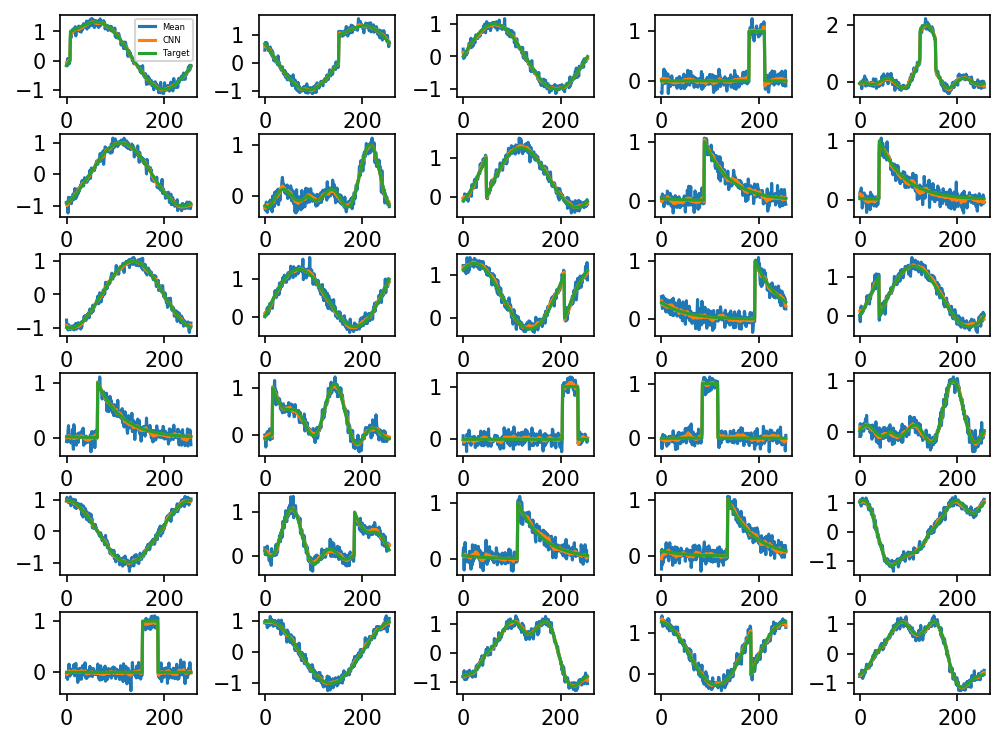

In [8]:
# Displaying some prediction results
plt.figure(figsize = (8,6),dpi = 150)
gs1 = gridspec.GridSpec(6, 5)
gs1.update(wspace=0.45, hspace=0.45)

test_unorm = test*norm_std + norm_mean
for ii in range(30):
    plt.subplot(gs1[ii])
    plt.plot(test_unorm[ii].mean(axis = -1).T,label = 'Mean')
    plt.plot(pred[ii,:,0],label = 'CNN')
    plt.plot(test_target[ii].T, label = "Target")
    if (ii == 0):
        plt.legend(fontsize = 4)
plt.show()

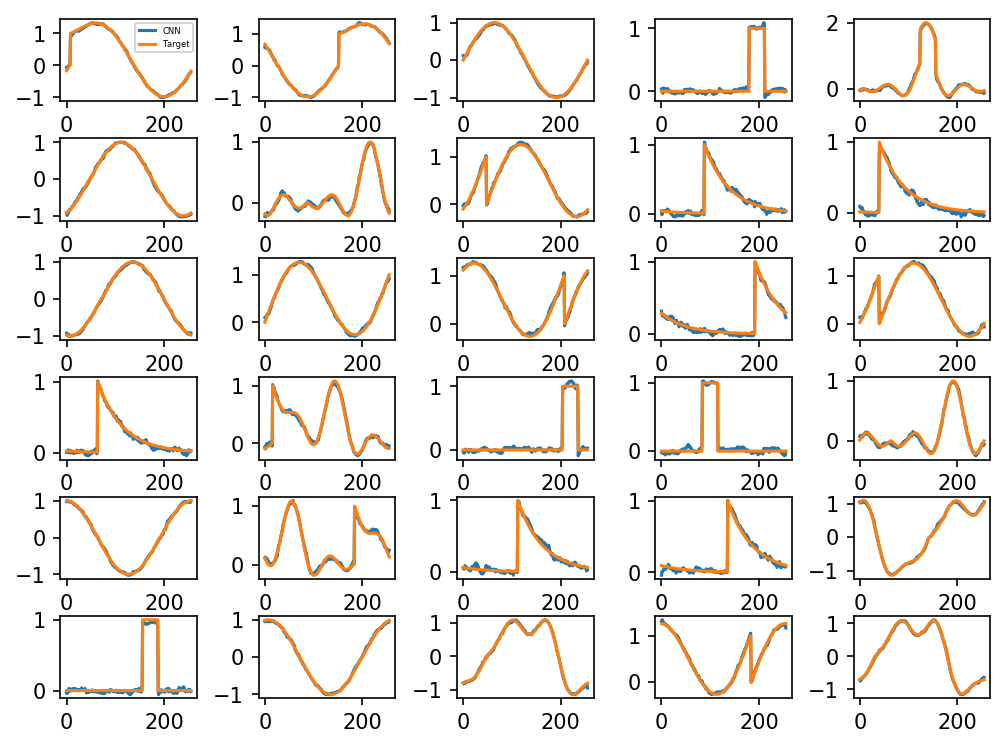

In [9]:
# Displaying some prediction results
plt.figure(figsize = (8,6),dpi = 150)
gs1 = gridspec.GridSpec(6, 5)
gs1.update(wspace=0.45, hspace=0.45)

test_unorm = test*norm_std + norm_mean
for ii in range(30):
    plt.subplot(gs1[ii])
    plt.plot(pred[ii,:,0],label = 'CNN')
    plt.plot(test_target[ii].T, label = "Target")
    if (ii == 0):
        plt.legend(fontsize = 4)
plt.show()